# Notebook Projet Deep Learning : CREDIT FRAUD
--------------
## M2 - MLDS - Formation Altérnance
### Étudiants :
* HADDAD Ayale (haddad.ayale@gmail.com) 
* ISSELNANE Hacene (hacene.isselnane@etu.u-paris.fr)

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### 1. Preparation des donn´ees

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('creditcard.csv')
raw_df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [6]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)


In [7]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [8]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


C:\Users\Wizard\Anaconda3\envs\keras-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Wizard\Anaconda3\envs\keras-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


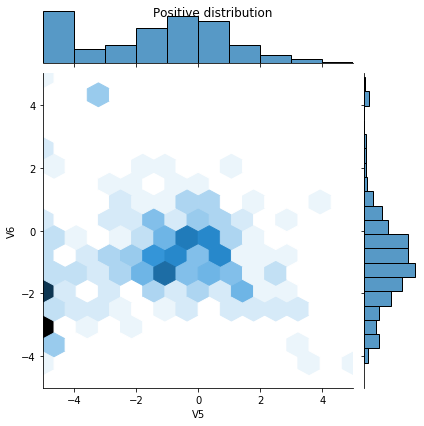

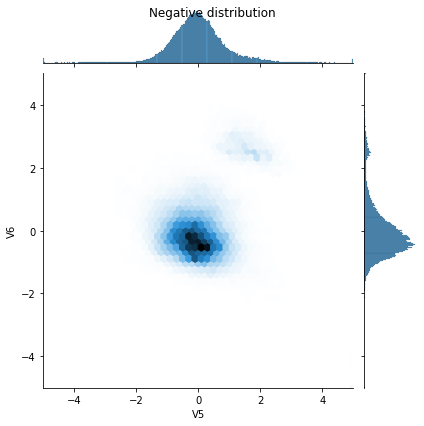

In [9]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")


In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model_baseline(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

## Baseline model

In [17]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [18]:
model = make_model_baseline()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.predict(train_features[:10])

array([[0.24883692],
       [0.4551041 ],
       [0.38973746],
       [0.27507693],
       [0.12741001],
       [0.16559543],
       [0.39342228],
       [0.14911169],
       [0.14891021],
       [0.42001235]], dtype=float32)

In [20]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.3125


In [21]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [22]:
model = make_model_baseline(output_bias=initial_bias)
model.predict(train_features[:10])


array([[0.00297501],
       [0.00287696],
       [0.00327447],
       [0.00182914],
       [0.00220462],
       [0.00643607],
       [0.00200627],
       [0.00506471],
       [0.00516994],
       [0.00192577]], dtype=float32)

In [23]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))


Loss: 0.0153


In [24]:
initial_weights_baseline = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights_baseline)


In [25]:
model = make_model_baseline()
model.load_weights(initial_weights_baseline)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [26]:
model = make_model_baseline()
model.load_weights(initial_weights_baseline)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [27]:
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch, history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()


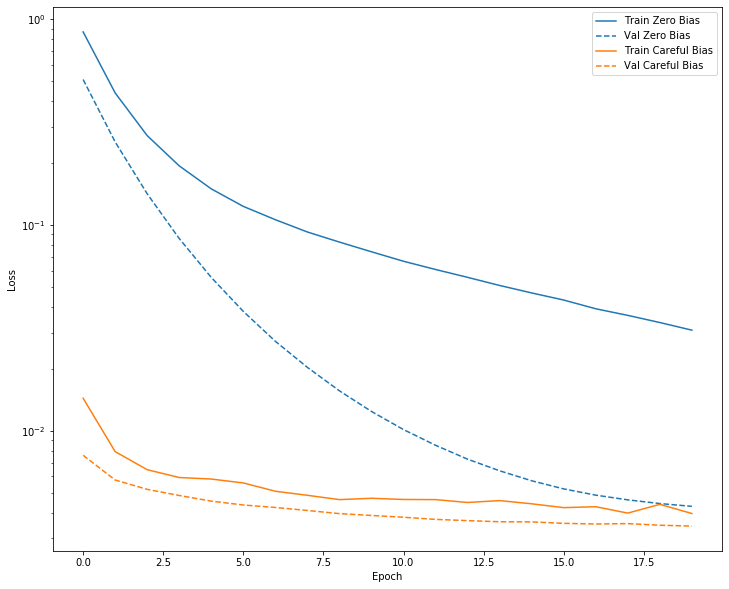

In [28]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)


In [29]:
model = make_model_baseline()
model.load_weights(initial_weights_baseline)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))


Train on 182276 samples, validate on 45569 samples
Epoch 1/100
182276/182276 [==============================] - 3s 17us/sample - loss: 0.0151 - tp: 43.0000 - fp: 240.0000 - tn: 181734.0000 - fn: 259.0000 - accuracy: 0.9973 - precision: 0.1519 - recall: 0.1424 - auc: 0.7705 - val_loss: 0.0078 - val_tp: 23.0000 - val_fp: 7.0000 - val_tn: 45469.0000 - val_fn: 70.0000 - val_accuracy: 0.9983 - val_precision: 0.7667 - val_recall: 0.2473 - val_auc: 0.9040
Epoch 2/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.0080 - tp: 116.0000 - fp: 38.0000 - tn: 181936.0000 - fn: 186.0000 - accuracy: 0.9988 - precision: 0.7532 - recall: 0.3841 - auc: 0.8826 - val_loss: 0.0059 - val_tp: 47.0000 - val_fp: 7.0000 - val_tn: 45469.0000 - val_fn: 46.0000 - val_accuracy: 0.9988 - val_precision: 0.8704 - val_recall: 0.5054 - val_auc: 0.9177
Epoch 3/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.0068 - tp: 125.0000 - fp: 27.0000 - tn: 181947.0000 - fn: 177

In [30]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
        plt.ylim([0.8,1])
    else:
        plt.ylim([0,1])
    plt.legend()

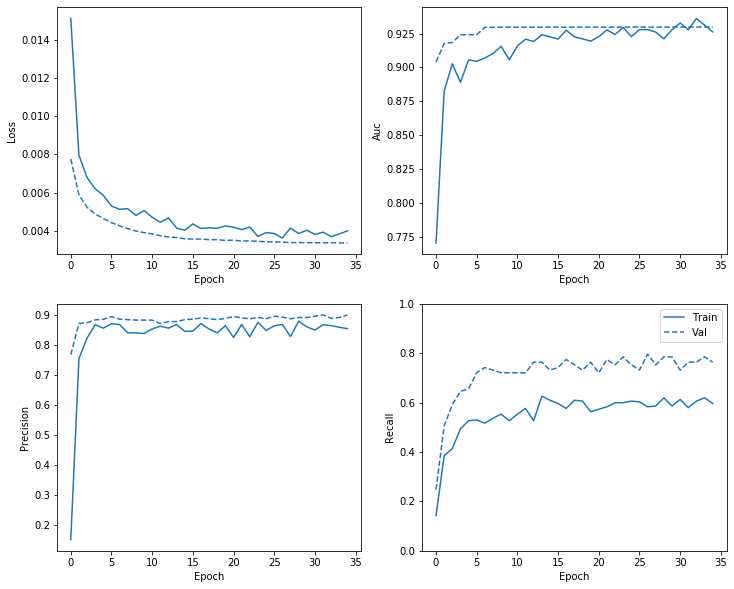

In [31]:
plot_metrics(baseline_history)

In [32]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))


In [33]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)


loss :  0.00183202821466107
tp :  85.0
fp :  7.0
tn :  56858.0
fn :  12.0
accuracy :  0.99966645
precision :  0.92391306
recall :  0.87628865
auc :  0.9637499

Legitimate Transactions Detected (True Negatives):  56858
Legitimate Transactions Incorrectly Detected (False Positives):  7
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  85
Total Fraudulent Transactions:  97


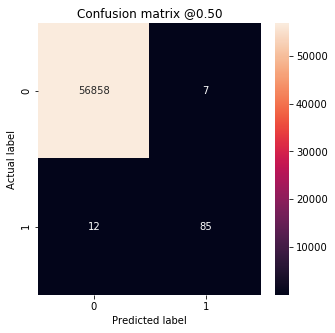

In [34]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()
plot_cm(test_labels, test_predictions_baseline)


In [35]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')


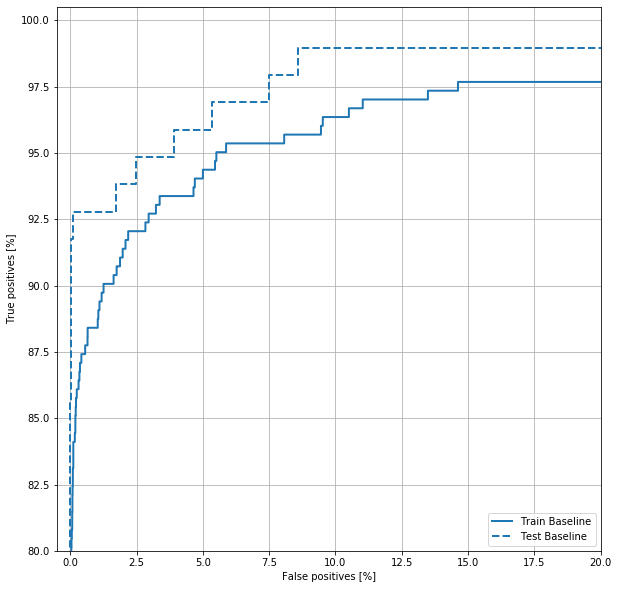

In [36]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')


### Modele plus elaboré

In [37]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
def make_model_elab(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          128, activation='relu',
          input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(
          64, activation='relu',
          input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(
          32, activation='relu',
          input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(
          32, activation='relu',
          input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [42]:
model = make_model_elab()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 128)               3840      
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)               

In [43]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.4462


In [44]:
initial_weights_elab = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights_elab)
model = make_model_elab()
model.load_weights(initial_weights_elab)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [102]:
model_elab = make_model_elab()
model.load_weights(initial_weights_elab)
careful_bias_history = model_elab.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

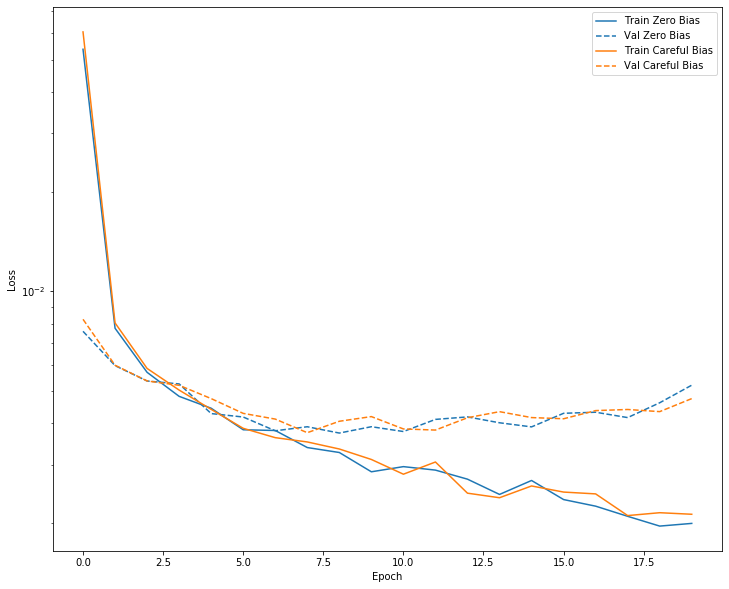

In [38]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

loss :  0.0024994821274489055
tp :  88.0
fp :  14.0
tn :  56851.0
fn :  9.0
accuracy :  0.99959624
precision :  0.8627451
recall :  0.9072165
auc :  0.9637459

Legitimate Transactions Detected (True Negatives):  56858
Legitimate Transactions Incorrectly Detected (False Positives):  7
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  85
Total Fraudulent Transactions:  97


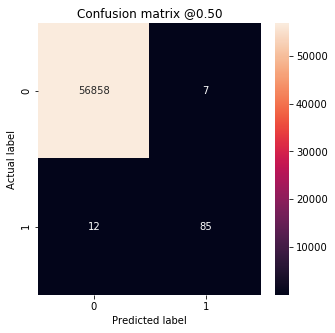

In [103]:
train_predictions_elab = model_elab.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_elab = model_elab.predict(test_features, batch_size=BATCH_SIZE)
elab_results = model_elab.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_elab.metrics_names, elab_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)


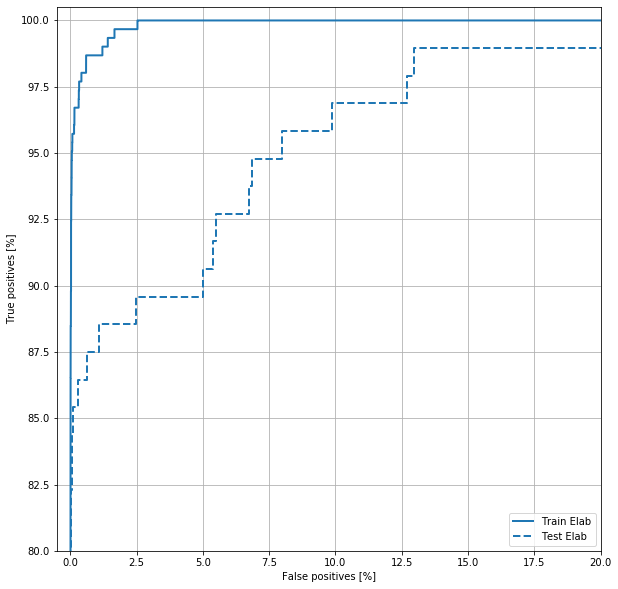

In [40]:
plot_roc("Train Elab", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Elab", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')


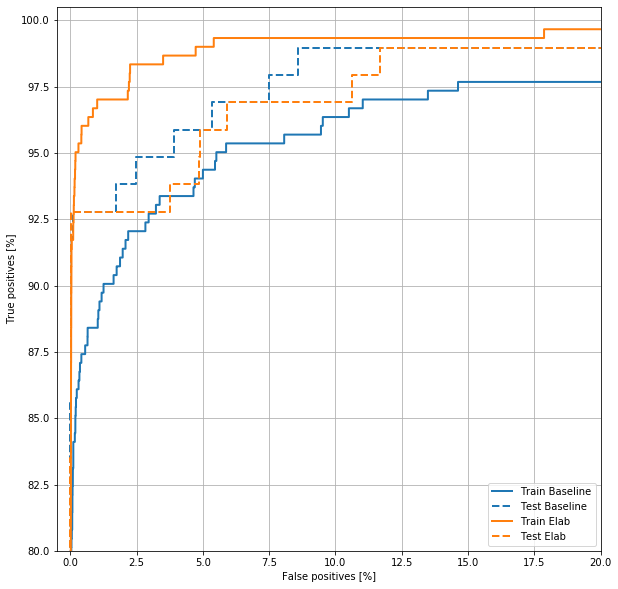

In [134]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Elab", train_labels, train_predictions_elab, color=colors[1])
plot_roc("Test Elab", test_labels, test_predictions_elab, color=colors[1], linestyle='--')
plt.legend(loc='lower right')

## Class weights

In [108]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 0.50
Weight for class 1: 289.44


In [112]:
weighted_model = make_model_baseline()
weighted_model.load_weights(initial_weights_baseline)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 182276 samples, validate on 45569 samples
Epoch 1/100
182276/182276 [==============================] - 3s 17us/sample - loss: 1.4148 - tp: 97.0000 - fp: 896.0000 - tn: 181078.0000 - fn: 205.0000 - accuracy: 0.9940 - precision: 0.0977 - recall: 0.3212 - auc: 0.8052 - val_loss: 0.7628 - val_tp: 59.0000 - val_fp: 91.0000 - val_tn: 45385.0000 - val_fn: 34.0000 - val_accuracy: 0.9973 - val_precision: 0.3933 - val_recall: 0.6344 - val_auc: 0.9360
Epoch 2/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.6644 - tp: 189.0000 - fp: 1633.0000 - tn: 180341.0000 - fn: 113.0000 - accuracy: 0.9904 - precision: 0.1037 - recall: 0.6258 - auc: 0.9123 - val_loss: 0.4993 - val_tp: 73.0000 - val_fp: 159.0000 - val_tn: 45317.0000 - val_fn: 20.0000 - val_accuracy: 0.9961 - val_precision: 0.3147 - val_recall: 0.7849 - val_auc: 0.9560
Epoch 3/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.5129 -

Epoch 21/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.2347 - tp: 266.0000 - fp: 7500.0000 - tn: 174474.0000 - fn: 36.0000 - accuracy: 0.9587 - precision: 0.0343 - recall: 0.8808 - auc: 0.9651 - val_loss: 0.2172 - val_tp: 83.0000 - val_fp: 1043.0000 - val_tn: 44433.0000 - val_fn: 10.0000 - val_accuracy: 0.9769 - val_precision: 0.0737 - val_recall: 0.8925 - val_auc: 0.9765
Epoch 22/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.2240 - tp: 270.0000 - fp: 7789.0000 - tn: 174185.0000 - fn: 32.0000 - accuracy: 0.9571 - precision: 0.0335 - recall: 0.8940 - auc: 0.9665 - val_loss: 0.2164 - val_tp: 83.0000 - val_fp: 994.0000 - val_tn: 44482.0000 - val_fn: 10.0000 - val_accuracy: 0.9780 - val_precision: 0.0771 - val_recall: 0.8925 - val_auc: 0.9771
Epoch 23/100
182276/182276 [==============================] - 1s 4us/sample - loss: 0.2176 - tp: 265.0000 - fp: 7232.0000 - tn: 174742.0000 - fn: 37.0000 - accuracy: 0.9601 - precision: 0.0

182276/182276 [==============================] - 1s 3us/sample - loss: 0.1635 - tp: 276.0000 - fp: 6266.0000 - tn: 175708.0000 - fn: 26.0000 - accuracy: 0.9655 - precision: 0.0422 - recall: 0.9139 - auc: 0.9838 - val_loss: 0.1822 - val_tp: 83.0000 - val_fp: 890.0000 - val_tn: 44586.0000 - val_fn: 10.0000 - val_accuracy: 0.9802 - val_precision: 0.0853 - val_recall: 0.8925 - val_auc: 0.9849
Epoch 62/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.1527 - tp: 279.0000 - fp: 5920.0000 - tn: 176054.0000 - fn: 23.0000 - accuracy: 0.9674 - precision: 0.0450 - recall: 0.9238 - auc: 0.9834 - val_loss: 0.1828 - val_tp: 83.0000 - val_fp: 883.0000 - val_tn: 44593.0000 - val_fn: 10.0000 - val_accuracy: 0.9804 - val_precision: 0.0859 - val_recall: 0.8925 - val_auc: 0.9847
Epoch 63/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.1465 - tp: 279.0000 - fp: 6032.0000 - tn: 175942.0000 - fn: 23.0000 - accuracy: 0.9668 - precision: 0.0442 - recall: 

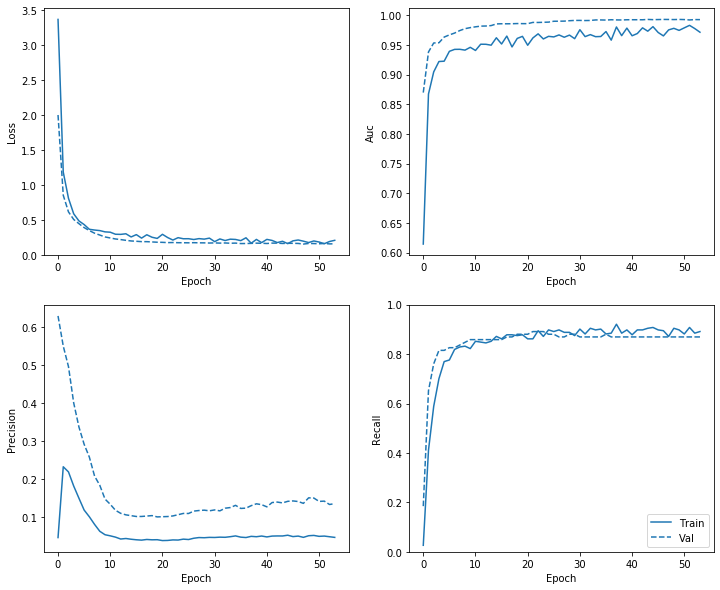

In [43]:
plot_metrics(weighted_history)

loss :  0.08999590927858642
tp :  91.0
fp :  1160.0
tn :  55705.0
fn :  6.0
accuracy :  0.9795302
precision :  0.07274181
recall :  0.9381443
auc :  0.9955592

Legitimate Transactions Detected (True Negatives):  55705
Legitimate Transactions Incorrectly Detected (False Positives):  1160
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  91
Total Fraudulent Transactions:  97


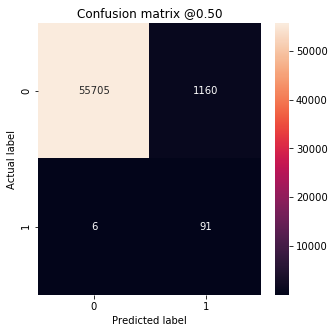

In [113]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)


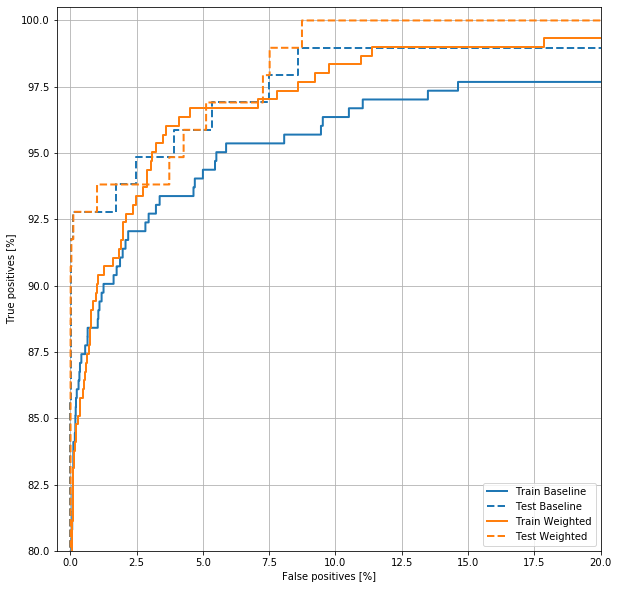

In [114]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')


### Modele elaboré

In [109]:
weighted_model_elab = make_model_elab()
weighted_model_elab.load_weights(initial_weights_elab)

weighted_history_elab = weighted_model_elab.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 182276 samples, validate on 45569 samples
Epoch 1/100
182276/182276 [==============================] - 6s 32us/sample - loss: 0.5178 - tp: 253.0000 - fp: 70726.0000 - tn: 111248.0000 - fn: 49.0000 - accuracy: 0.6117 - precision: 0.0036 - recall: 0.8377 - auc: 0.8427 - val_loss: 0.2480 - val_tp: 82.0000 - val_fp: 740.0000 - val_tn: 44736.0000 - val_fn: 11.0000 - val_accuracy: 0.9835 - val_precision: 0.0998 - val_recall: 0.8817 - val_auc: 0.9689
Epoch 2/100
182276/182276 [==============================] - 1s 4us/sample - loss: 0.2489 - tp: 274.0000 - fp: 14312.0000 - tn: 167662.0000 - fn: 28.0000 - accuracy: 0.9213 - precision: 0.0188 - recall: 0.9073 - auc: 0.9642 - val_loss: 0.1989 - val_tp: 85.0000 - val_fp: 1538.0000 - val_tn: 43938.0000 - val_fn: 8.0000 - val_accuracy: 0.9661 - val_precision: 0.0524 - val_recall: 0.9140 - val_auc: 0.9786
Epoch 3/100
182276/182276 [==============================] - 1s 4us/sample - loss: 0.217

Epoch 21/100
182276/182276 [==============================] - 1s 4us/sample - loss: 0.0400 - tp: 298.0000 - fp: 3012.0000 - tn: 178962.0000 - fn: 4.0000 - accuracy: 0.9835 - precision: 0.0900 - recall: 0.9868 - auc: 0.9987 - val_loss: 0.4255 - val_tp: 83.0000 - val_fp: 549.0000 - val_tn: 44927.0000 - val_fn: 10.0000 - val_accuracy: 0.9877 - val_precision: 0.1313 - val_recall: 0.8925 - val_auc: 0.9639
Epoch 00021: early stopping


loss :  0.07808120167262517
tp :  92.0
fp :  1865.0
tn :  55000.0
fn :  5.0
accuracy :  0.9671711
precision :  0.04701073
recall :  0.9484536
auc :  0.9966522

Legitimate Transactions Detected (True Negatives):  55000
Legitimate Transactions Incorrectly Detected (False Positives):  1865
Fraudulent Transactions Missed (False Negatives):  5
Fraudulent Transactions Detected (True Positives):  92
Total Fraudulent Transactions:  97


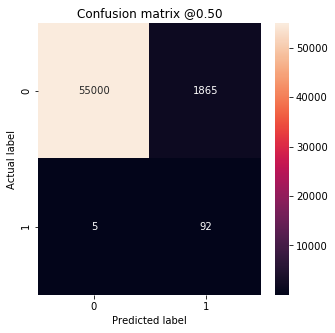

In [110]:
train_predictions_weighted_elab = weighted_model_elab.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted_elab = weighted_model_elab.predict(test_features, batch_size=BATCH_SIZE)

weighted_results_elab = weighted_model_elab.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model_elab.metrics_names, weighted_results_elab):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted_elab)

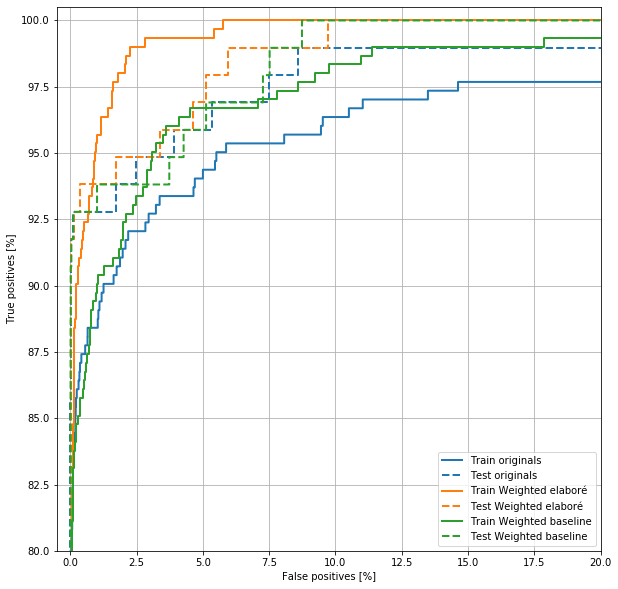

In [115]:
plot_roc("Train originals", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test originals", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')


plot_roc("Train Weighted elaboré", train_labels, train_predictions_weighted_elab, color=colors[1])
plot_roc("Test Weighted elaboré", test_labels, test_predictions_weighted_elab, color=colors[1], linestyle='--')

plot_roc("Train Weighted baseline", train_labels, train_predictions_weighted, color=colors[2])
plot_roc("Test Weighted baseline", test_labels, test_predictions_weighted, color=colors[2], linestyle='--')

plt.legend(loc='lower right')

## Oversampling
### Random Sampling

In [119]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]


In [120]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181974, 29)

In [121]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363948, 29)

In [122]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)


In [123]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())


Features:
 [ 0.51962047  1.2075048  -3.14099715  2.70279815 -0.92685676 -1.30776028
 -2.5006626   0.74214489  0.37453718 -3.63968648  3.50634371 -5.
  0.14798073 -5.          1.83467894 -3.01859394 -1.55741904 -0.46810811
  1.37221031  0.26293352  0.46646126 -0.07162787  1.12810922 -0.61863994
 -3.89336145  0.76203686  1.00338613  0.06279916 -1.45151981]

Label:  1


In [124]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

for features, label in resampled_ds.take(1):
    print(label.numpy().mean())


0.4833984375


In [125]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [126]:
resampled_model_baseline = make_model_baseline()
resampled_model_baseline.load_weights(initial_weights_baseline)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model_baseline.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model_baseline.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)


Train for 278.0 steps, validate for 23 steps
Epoch 1/100
278/278 [==============================] - 11s 39ms/step - loss: 0.4444 - tp: 253518.0000 - fp: 97387.0000 - tn: 187252.0000 - fn: 31187.0000 - accuracy: 0.7742 - precision: 0.7225 - recall: 0.8905 - auc: 0.9031 - val_loss: 0.2632 - val_tp: 83.0000 - val_fp: 1476.0000 - val_tn: 44000.0000 - val_fn: 10.0000 - val_accuracy: 0.9674 - val_precision: 0.0532 - val_recall: 0.8925 - val_auc: 0.9652
Epoch 2/100
278/278 [==============================] - 8s 28ms/step - loss: 0.2129 - tp: 259919.0000 - fp: 19237.0000 - tn: 265961.0000 - fn: 24227.0000 - accuracy: 0.9237 - precision: 0.9311 - recall: 0.9147 - auc: 0.9714 - val_loss: 0.1351 - val_tp: 83.0000 - val_fp: 985.0000 - val_tn: 44491.0000 - val_fn: 10.0000 - val_accuracy: 0.9782 - val_precision: 0.0777 - val_recall: 0.8925 - val_auc: 0.9750
Epoch 3/100
278/278 [==============================] - 8s 27ms/step - loss: 0.1653 - tp: 263061.0000 - fp: 12962.0000 - tn: 272534.0000 - fn: 207

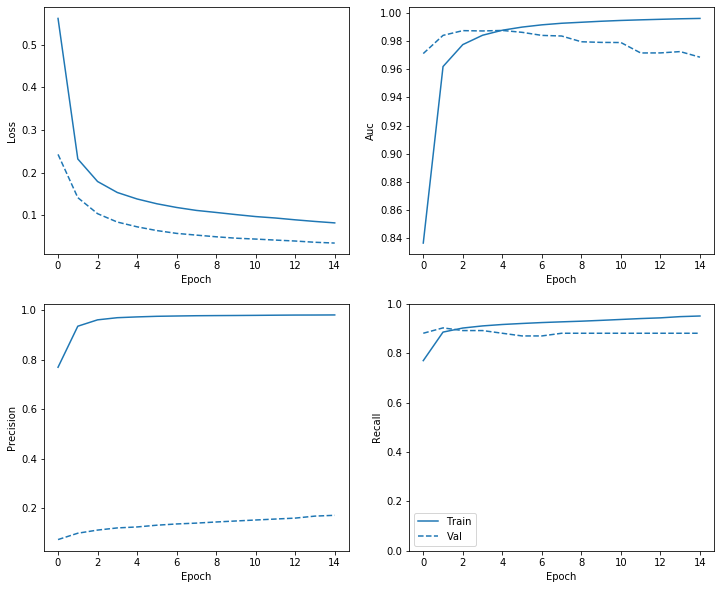

In [59]:
plot_metrics(resampled_history)

In [127]:
resampled_model_baseline = make_model_baseline()
resampled_model_baseline.load_weights(initial_weights_baseline)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model_baseline.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model_baseline.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))


Train for 20 steps, validate for 23 steps
Epoch 1/1000
20/20 [==============================] - 3s 146ms/step - loss: 0.8906 - tp: 15850.0000 - fp: 14941.0000 - tn: 5524.0000 - fn: 4645.0000 - accuracy: 0.5218 - precision: 0.5148 - recall: 0.7734 - auc: 0.6830 - val_loss: 1.0833 - val_tp: 90.0000 - val_fp: 37129.0000 - val_tn: 8347.0000 - val_fn: 3.0000 - val_accuracy: 0.1851 - val_precision: 0.0024 - val_recall: 0.9677 - val_auc: 0.9010
Epoch 2/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.6936 - tp: 17796.0000 - fp: 13957.0000 - tn: 6559.0000 - fn: 2648.0000 - accuracy: 0.5946 - precision: 0.5605 - recall: 0.8705 - auc: 0.8087 - val_loss: 0.9744 - val_tp: 91.0000 - val_fp: 34104.0000 - val_tn: 11372.0000 - val_fn: 2.0000 - val_accuracy: 0.2516 - val_precision: 0.0027 - val_recall: 0.9785 - val_auc: 0.9225
Epoch 3/1000
20/20 [==============================] - 1s 27ms/step - loss: 0.6053 - tp: 18249.0000 - fp: 12796.0000 - tn: 7807.0000 - fn: 2108.0000 - accuracy

20/20 [==============================] - 1s 25ms/step - loss: 0.1531 - tp: 18939.0000 - fp: 863.0000 - tn: 19795.0000 - fn: 1363.0000 - accuracy: 0.9457 - precision: 0.9564 - recall: 0.9329 - auc: 0.9859 - val_loss: 0.1003 - val_tp: 83.0000 - val_fp: 867.0000 - val_tn: 44609.0000 - val_fn: 10.0000 - val_accuracy: 0.9808 - val_precision: 0.0874 - val_recall: 0.8925 - val_auc: 0.9780
Epoch 42/1000
20/20 [==============================] - 1s 25ms/step - loss: 0.1527 - tp: 19064.0000 - fp: 866.0000 - tn: 19657.0000 - fn: 1373.0000 - accuracy: 0.9453 - precision: 0.9565 - recall: 0.9328 - auc: 0.9859 - val_loss: 0.0982 - val_tp: 84.0000 - val_fp: 851.0000 - val_tn: 44625.0000 - val_fn: 9.0000 - val_accuracy: 0.9811 - val_precision: 0.0898 - val_recall: 0.9032 - val_auc: 0.9781
Epoch 43/1000
20/20 [==============================] - 1s 25ms/step - loss: 0.1500 - tp: 19151.0000 - fp: 847.0000 - tn: 19582.0000 - fn: 1380.0000 - accuracy: 0.9456 - precision: 0.9576 - recall: 0.9328 - auc: 0.9863

Epoch 62/1000
20/20 [==============================] - 1s 25ms/step - loss: 0.1305 - tp: 19361.0000 - fp: 726.0000 - tn: 19624.0000 - fn: 1249.0000 - accuracy: 0.9518 - precision: 0.9639 - recall: 0.9394 - auc: 0.9902 - val_loss: 0.0759 - val_tp: 84.0000 - val_fp: 751.0000 - val_tn: 44725.0000 - val_fn: 9.0000 - val_accuracy: 0.9833 - val_precision: 0.1006 - val_recall: 0.9032 - val_auc: 0.9784
Epoch 63/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.1257 - tp: 19076.0000 - fp: 677.0000 - tn: 19992.0000 - fn: 1215.0000 - accuracy: 0.9538 - precision: 0.9657 - recall: 0.9401 - auc: 0.9911 - val_loss: 0.0744 - val_tp: 84.0000 - val_fp: 730.0000 - val_tn: 44746.0000 - val_fn: 9.0000 - val_accuracy: 0.9838 - val_precision: 0.1032 - val_recall: 0.9032 - val_auc: 0.9782
Epoch 64/1000
20/20 [==============================] - 1s 27ms/step - loss: 0.1232 - tp: 19334.0000 - fp: 659.0000 - tn: 19777.0000 - fn: 1190.0000 - accuracy: 0.9549 - precision: 0.9670 - recall: 0.9420 

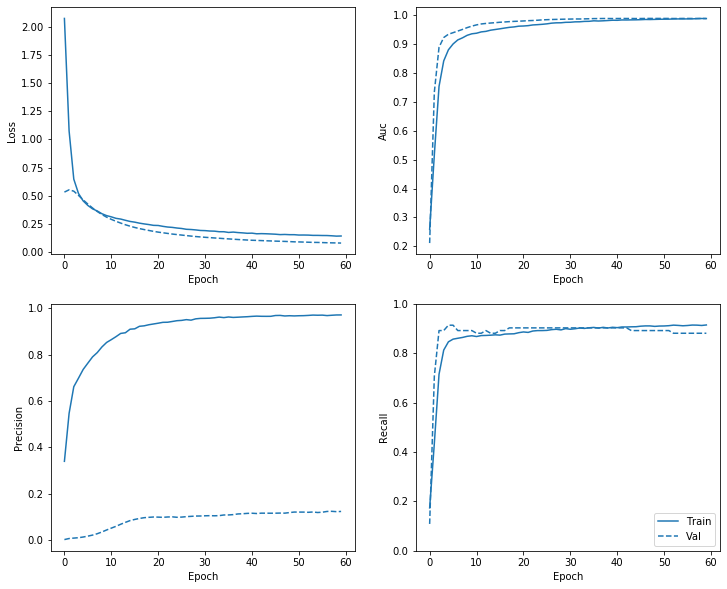

In [61]:
plot_metrics(resampled_history)


In [128]:
train_predictions_resampled = resampled_model_baseline.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model_baseline.predict(test_features, batch_size=BATCH_SIZE)


loss :  0.07742010851394159
tp :  91.0
fp :  1019.0
tn :  55846.0
fn :  6.0
accuracy :  0.98200554
precision :  0.08198198
recall :  0.9381443
auc :  0.9957168

Legitimate Transactions Detected (True Negatives):  55846
Legitimate Transactions Incorrectly Detected (False Positives):  1019
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  91
Total Fraudulent Transactions:  97


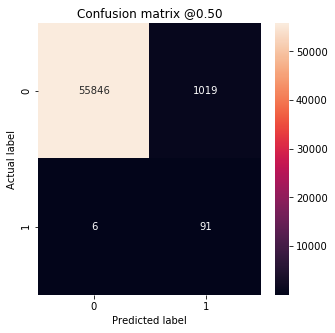

In [129]:
resampled_results = resampled_model_baseline.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model_baseline.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)


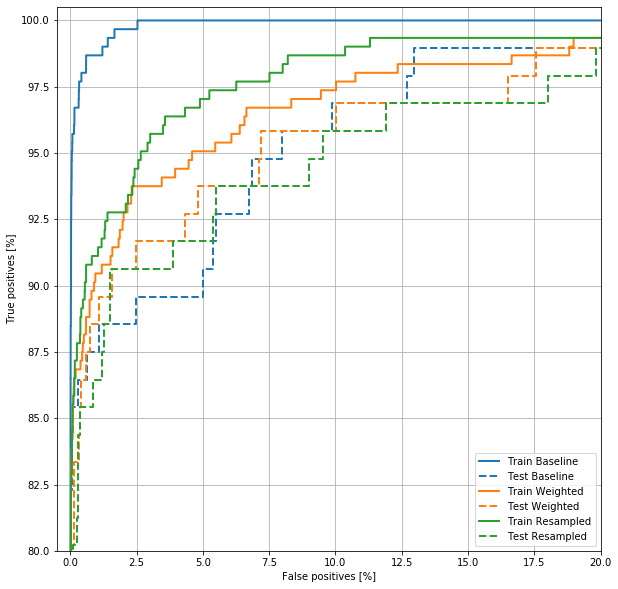

In [65]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')


### Modele elaboré

In [130]:
resampled_model_elab = make_model_elab()
resampled_model_elab.load_weights(initial_weights_elab)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model_elab.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model_elab.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train for 278.0 steps, validate for 23 steps
Epoch 1/100
278/278 [==============================] - 10s 36ms/step - loss: 0.1255 - tp: 268866.0000 - fp: 11668.0000 - tn: 272971.0000 - fn: 15839.0000 - accuracy: 0.9517 - precision: 0.9584 - recall: 0.9444 - auc: 0.9907 - val_loss: 0.0201 - val_tp: 83.0000 - val_fp: 237.0000 - val_tn: 45239.0000 - val_fn: 10.0000 - val_accuracy: 0.9946 - val_precision: 0.2594 - val_recall: 0.8925 - val_auc: 0.9554
Epoch 2/100
278/278 [==============================] - 7s 26ms/step - loss: 0.0159 - tp: 283600.0000 - fp: 1581.0000 - tn: 283617.0000 - fn: 546.0000 - accuracy: 0.9963 - precision: 0.9945 - recall: 0.9981 - auc: 0.9995 - val_loss: 0.0136 - val_tp: 80.0000 - val_fp: 86.0000 - val_tn: 45390.0000 - val_fn: 13.0000 - val_accuracy: 0.9978 - val_precision: 0.4819 - val_recall: 0.8602 - val_auc: 0.9401
Epoch 3/100
278/278 [==============================] - 7s 27ms/step - loss: 0.0087 - tp: 283613.0000 - fp: 795.0000 - tn: 284701.0000 - fn: 235.0000 -

In [131]:
resampled_model_elab = make_model_elab()
resampled_model_elab.load_weights(initial_weights_elab)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model_elab.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model_elab.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Train for 20 steps, validate for 23 steps
Epoch 1/1000
20/20 [==============================] - 5s 237ms/step - loss: 0.6049 - tp: 13378.0000 - fp: 5170.0000 - tn: 15295.0000 - fn: 7117.0000 - accuracy: 0.7000 - precision: 0.7213 - recall: 0.6527 - auc: 0.7383 - val_loss: 0.4301 - val_tp: 83.0000 - val_fp: 2024.0000 - val_tn: 43452.0000 - val_fn: 10.0000 - val_accuracy: 0.9554 - val_precision: 0.0394 - val_recall: 0.8925 - val_auc: 0.9598
Epoch 2/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.2942 - tp: 17811.0000 - fp: 1335.0000 - tn: 19181.0000 - fn: 2633.0000 - accuracy: 0.9031 - precision: 0.9303 - recall: 0.8712 - auc: 0.9440 - val_loss: 0.1461 - val_tp: 84.0000 - val_fp: 1524.0000 - val_tn: 43952.0000 - val_fn: 9.0000 - val_accuracy: 0.9664 - val_precision: 0.0522 - val_recall: 0.9032 - val_auc: 0.9718
Epoch 3/1000
20/20 [==============================] - 1s 27ms/step - loss: 0.1889 - tp: 18703.0000 - fp: 941.0000 - tn: 19662.0000 - fn: 1654.0000 - accuracy:

loss :  0.07559631723294637
tp :  91.0
fp :  1571.0
tn :  55294.0
fn :  6.0
accuracy :  0.9723149
precision :  0.05475331
recall :  0.9381443
auc :  0.9957694

Legitimate Transactions Detected (True Negatives):  55294
Legitimate Transactions Incorrectly Detected (False Positives):  1571
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  91
Total Fraudulent Transactions:  97


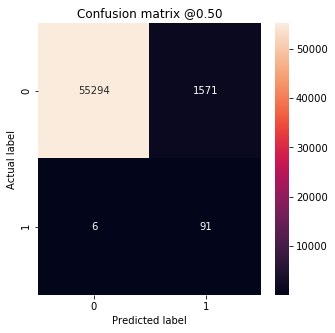

In [132]:
train_predictions_resampled_elab = resampled_model_elab.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled_elab = resampled_model_elab.predict(test_features, batch_size=BATCH_SIZE)
resampled_results_elab = resampled_model_elab.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model_elab.metrics_names, resampled_results_elab):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled_elab)


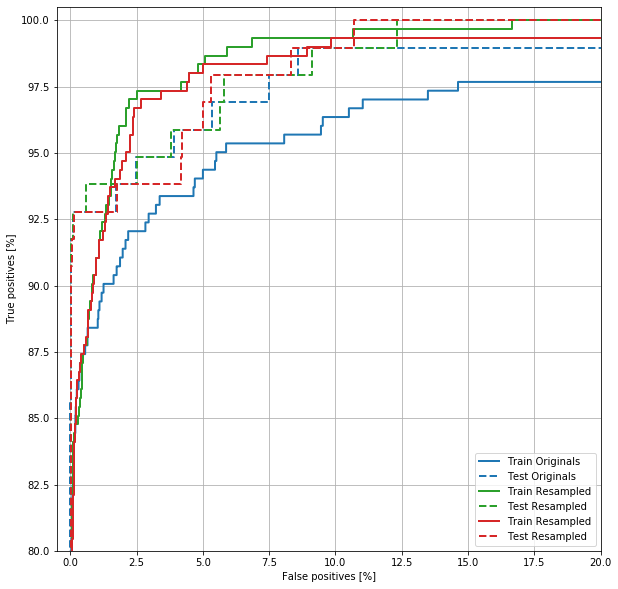

In [133]:
plot_roc("Train Originals", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Originals", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')


plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

plot_roc("Train Resampled", train_labels, train_predictions_resampled_elab, color=colors[3])
plot_roc("Test Resampled", test_labels, test_predictions_resampled_elab, color=colors[3], linestyle='--')
plt.legend(loc='lower right')

### SMOTE

In [63]:
from imblearn.over_sampling import SMOTE

In [64]:
train_features_SMOTE, train_labels_SMOTE = SMOTE().fit_sample(train_features, train_labels)

In [65]:
smote_model_baseline = make_model_baseline()
smote_model_baseline.load_weights(initial_weights_baseline)

# Reset the bias to zero, since this dataset is balanced.
output_layer = smote_model_baseline.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = smote_model_baseline.fit(
    train_features_SMOTE,
    train_labels_SMOTE,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train on 363948 samples, validate for 23 steps
Epoch 1/10
363948/363948 [==============================] - 60s 166us/sample - loss: 0.1295 - tp: 170007.0000 - fp: 7932.0000 - tn: 174042.0000 - fn: 11967.0000 - accuracy: 0.9453 - precision: 0.9554 - recall: 0.9342 - auc: 0.9900 - val_loss: 0.0336 - val_tp: 83.0000 - val_fp: 522.0000 - val_tn: 44954.0000 - val_fn: 10.0000 - val_accuracy: 0.9883 - val_precision: 0.1372 - val_recall: 0.8925 - val_auc: 0.9672
Epoch 2/10
363948/363948 [==============================] - 58s 158us/sample - loss: 0.0746 - tp: 176731.0000 - fp: 6043.0000 - tn: 175931.0000 - fn: 5243.0000 - accuracy: 0.9690 - precision: 0.9669 - recall: 0.9712 - auc: 0.9964 - val_loss: 0.0291 - val_tp: 82.0000 - val_fp: 452.0000 - val_tn: 45024.0000 - val_fn: 11.0000 - val_accuracy: 0.9898 - val_precision: 0.1536 - val_recall: 0.8817 - val_auc: 0.9543
Epoch 3/10
363948/363948 [==============================] - 57s 157us/sample - loss: 0.0685 - tp: 177624.0000 - fp: 6317.0000 - tn

loss :  0.023439611728109194
tp :  90.0
fp :  452.0
tn :  56413.0
fn :  7.0
accuracy :  0.991942
precision :  0.16605166
recall :  0.92783505
auc :  0.9681483

Legitimate Transactions Detected (True Negatives):  56413
Legitimate Transactions Incorrectly Detected (False Positives):  452
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  90
Total Fraudulent Transactions:  97


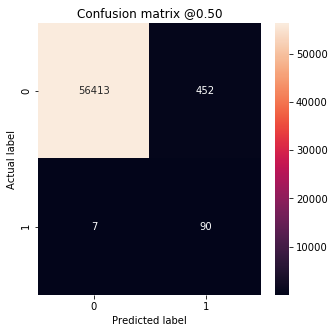

In [66]:
train_predictions_smote_baseline = smote_model_baseline.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_smote_baseline = smote_model_baseline.predict(test_features, batch_size=BATCH_SIZE)
smote_results_baseline = smote_model_baseline.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(smote_model_baseline.metrics_names, smote_results_baseline):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_smote_baseline)

### modele elaboré

In [69]:
smote_model_elab = make_model_elab()
smote_model_elab.load_weights(initial_weights_elab)

# Reset the bias to zero, since this dataset is balanced.
output_layer = smote_model_baseline.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = smote_model_elab.fit(
    train_features_SMOTE,
    train_labels_SMOTE,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train on 363948 samples, validate for 23 steps
Epoch 1/10
363948/363948 [==============================] - 71s 196us/sample - loss: 0.0212 - tp: 181113.0000 - fp: 1599.0000 - tn: 180375.0000 - fn: 861.0000 - accuracy: 0.9932 - precision: 0.9912 - recall: 0.9953 - auc: 0.9994 - val_loss: 0.0113 - val_tp: 80.0000 - val_fp: 54.0000 - val_tn: 45422.0000 - val_fn: 13.0000 - val_accuracy: 0.9985 - val_precision: 0.5970 - val_recall: 0.8602 - val_auc: 0.9404
Epoch 2/10
363948/363948 [==============================] - 65s 177us/sample - loss: 0.0062 - tp: 181834.0000 - fp: 365.0000 - tn: 181609.0000 - fn: 140.0000 - accuracy: 0.9986 - precision: 0.9980 - recall: 0.9992 - auc: 0.9997 - val_loss: 0.0161 - val_tp: 79.0000 - val_fp: 98.0000 - val_tn: 45378.0000 - val_fn: 14.0000 - val_accuracy: 0.9975 - val_precision: 0.4463 - val_recall: 0.8495 - val_auc: 0.9346
Epoch 3/10
363948/363948 [==============================] - 74s 204us/sample - loss: 0.0049 - tp: 181884.0000 - fp: 288.0000 - tn: 18168

loss :  0.011403962594621536
tp :  90.0
fp :  19.0
tn :  56846.0
fn :  7.0
accuracy :  0.99954355
precision :  0.82568806
recall :  0.92783505
auc :  0.9638168

Legitimate Transactions Detected (True Negatives):  56846
Legitimate Transactions Incorrectly Detected (False Positives):  19
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  90
Total Fraudulent Transactions:  97


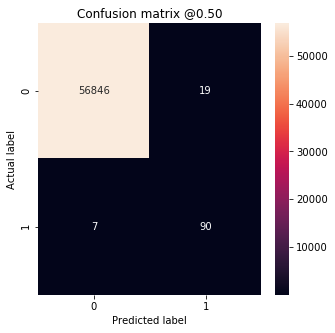

In [71]:
train_predictions_smote_elab = smote_model_elab.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_smote_elab = smote_model_elab.predict(test_features, batch_size=BATCH_SIZE)
smote_results_elab = smote_model_elab.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(smote_model_elab.metrics_names, smote_results_elab):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_smote_elab)

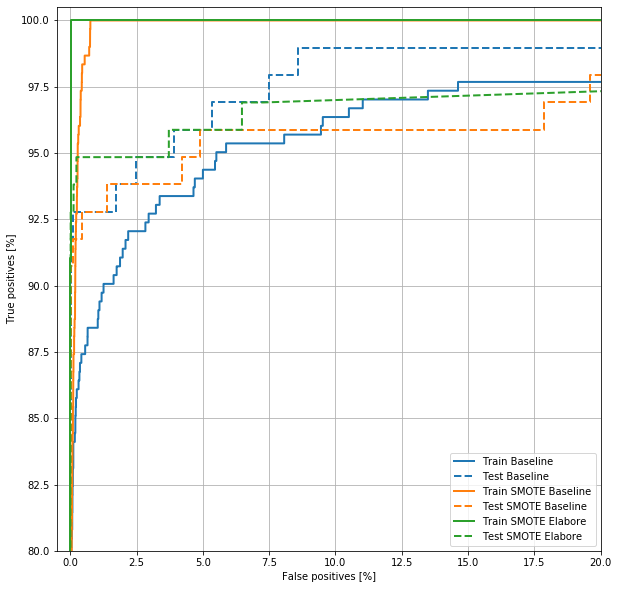

In [137]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train SMOTE Baseline", train_labels, train_predictions_smote_baseline, color=colors[1])
plot_roc("Test SMOTE Baseline", test_labels, test_predictions_smote_baseline, color=colors[1], linestyle='--')

plot_roc("Train SMOTE Elabore", train_labels, train_predictions_smote_elab, color=colors[2])
plot_roc("Test SMOTE Elabore", test_labels, test_predictions_smote_elab, color=colors[2], linestyle='--')


plt.legend(loc='lower right')

### ADASYN (Adaptive Synthetic)

In [77]:
from imblearn.over_sampling import ADASYN 
ada = ADASYN(random_state=42)
train_features_ADASYN, train_labels_ADASYN = ada.fit_resample(train_features, train_labels)

In [78]:
adasyn_model_baseline = make_model_baseline()
adasyn_model_baseline.load_weights(initial_weights_baseline)

# Reset the bias to zero, since this dataset is balanced.
output_layer = adasyn_model_baseline.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = adasyn_model_baseline.fit(
    train_features_ADASYN,
    train_labels_ADASYN,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train on 363947 samples, validate for 23 steps
Epoch 1/10
363947/363947 [==============================] - 63s 174us/sample - loss: 0.1840 - tp: 172559.0000 - fp: 16314.0000 - tn: 165660.0000 - fn: 9414.0000 - accuracy: 0.9293 - precision: 0.9136 - recall: 0.9483 - auc: 0.9798 - val_loss: 0.0477 - val_tp: 84.0000 - val_fp: 835.0000 - val_tn: 44641.0000 - val_fn: 9.0000 - val_accuracy: 0.9815 - val_precision: 0.0914 - val_recall: 0.9032 - val_auc: 0.9577
Epoch 2/10
363947/363947 [==============================] - 63s 173us/sample - loss: 0.1164 - tp: 181375.0000 - fp: 17322.0000 - tn: 164652.0000 - fn: 598.0000 - accuracy: 0.9508 - precision: 0.9128 - recall: 0.9967 - auc: 0.9898 - val_loss: 0.0369 - val_tp: 82.0000 - val_fp: 620.0000 - val_tn: 44856.0000 - val_fn: 11.0000 - val_accuracy: 0.9862 - val_precision: 0.1168 - val_recall: 0.8817 - val_auc: 0.9542
Epoch 3/10
363947/363947 [==============================] - 64s 177us/sample - loss: 0.1094 - tp: 181657.0000 - fp: 16290.0000 - tn

loss :  0.029792067454249845
tp :  88.0
fp :  525.0
tn :  56340.0
fn :  9.0
accuracy :  0.9906253
precision :  0.14355628
recall :  0.9072165
auc :  0.9525004

Legitimate Transactions Detected (True Negatives):  56340
Legitimate Transactions Incorrectly Detected (False Positives):  525
Fraudulent Transactions Missed (False Negatives):  9
Fraudulent Transactions Detected (True Positives):  88
Total Fraudulent Transactions:  97


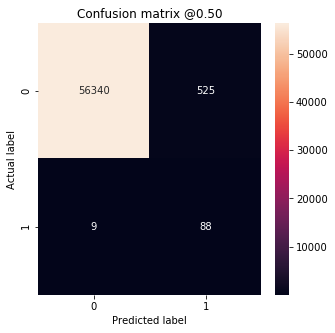

In [79]:
train_predictions_adasyn_baseline = adasyn_model_baseline.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_adasyn_baseline = adasyn_model_baseline.predict(test_features, batch_size=BATCH_SIZE)
adasyn_results_baseline = adasyn_model_baseline.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(adasyn_model_baseline.metrics_names, adasyn_results_baseline):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_adasyn_baseline)

## Modele Elaboré

In [80]:
adasyn_model_elab = make_model_elab()
adasyn_model_elab.load_weights(initial_weights_elab)

# Reset the bias to zero, since this dataset is balanced.
output_layer = adasyn_model_elab.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = adasyn_model_elab.fit(
    train_features_ADASYN,
    train_labels_ADASYN,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train on 363947 samples, validate for 23 steps
Epoch 1/10
363947/363947 [==============================] - 75s 205us/sample - loss: 0.0272 - tp: 180879.0000 - fp: 1854.0000 - tn: 180120.0000 - fn: 1094.0000 - accuracy: 0.9919 - precision: 0.9899 - recall: 0.9940 - auc: 0.9989 - val_loss: 0.0143 - val_tp: 80.0000 - val_fp: 98.0000 - val_tn: 45378.0000 - val_fn: 13.0000 - val_accuracy: 0.9976 - val_precision: 0.4494 - val_recall: 0.8602 - val_auc: 0.9344
Epoch 2/10
363947/363947 [==============================] - 68s 185us/sample - loss: 0.0074 - tp: 181842.0000 - fp: 376.0000 - tn: 181598.0000 - fn: 131.0000 - accuracy: 0.9986 - precision: 0.9979 - recall: 0.9993 - auc: 0.9995 - val_loss: 0.0158 - val_tp: 79.0000 - val_fp: 41.0000 - val_tn: 45435.0000 - val_fn: 14.0000 - val_accuracy: 0.9988 - val_precision: 0.6583 - val_recall: 0.8495 - val_auc: 0.9243
Epoch 3/10
363947/363947 [==============================] - 65s 179us/sample - loss: 0.0049 - tp: 181892.0000 - fp: 256.0000 - tn: 1817

loss :  0.011403962594621536
tp :  90.0
fp :  19.0
tn :  56846.0
fn :  7.0
accuracy :  0.99954355
precision :  0.82568806
recall :  0.92783505
auc :  0.9638168

Legitimate Transactions Detected (True Negatives):  56842
Legitimate Transactions Incorrectly Detected (False Positives):  23
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  90
Total Fraudulent Transactions:  97


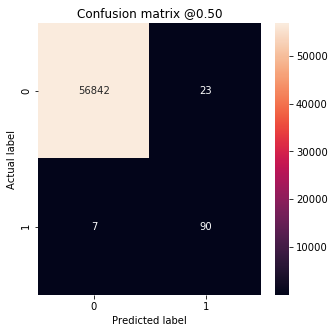

In [81]:
train_predictions_adasyn_elab = adasyn_model_elab.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_adasyn_elab = adasyn_model_elab.predict(test_features, batch_size=BATCH_SIZE)
adasyn_results_elab = adasyn_model_elab.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(adasyn_model_elab.metrics_names, smote_results_elab):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_adasyn_elab)

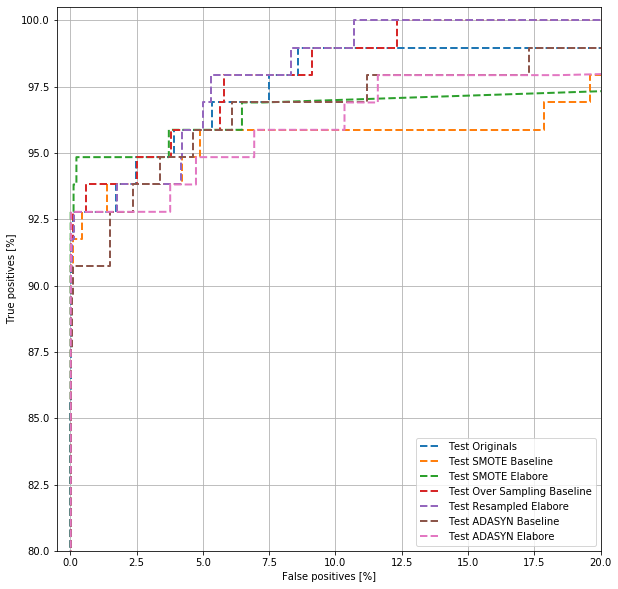

In [138]:
plot_roc("Test Originals", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Test SMOTE Baseline", test_labels, test_predictions_smote_baseline, color=colors[1], linestyle='--')
plot_roc("Test SMOTE Elabore", test_labels, test_predictions_smote_elab, color=colors[2], linestyle='--')
plot_roc("Test Over Sampling Baseline", test_labels, test_predictions_resampled, color=colors[3], linestyle='--')
plot_roc("Test Resampled Elabore", test_labels, test_predictions_resampled_elab, color=colors[4], linestyle='--')
plot_roc("Test ADASYN Baseline", test_labels, test_predictions_adasyn_baseline, color=colors[5], linestyle='--')
plot_roc("Test ADASYN Elabore", test_labels, test_predictions_adasyn_elab, color=colors[6], linestyle='--')
plt.legend(loc='lower right')

### Tomek Links

In [15]:
from imblearn.under_sampling import TomekLinks
underTomek = TomekLinks()
features_under_tomek, labels_under_tomek = underTomek.fit_resample(train_features, train_labels)

In [39]:
tomek_model_baseline = make_model_baseline()
tomek_model_baseline.load_weights(initial_weights_baseline)

# Reset the bias to zero, since this dataset is balanced.
output_layer = tomek_model_baseline.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = tomek_model_baseline.fit(
    features_under_tomek, 
    labels_under_tomek,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train on 182262 samples, validate for 23 steps
Epoch 1/10
182262/182262 [==============================] - 30s 167us/sample - loss: 0.0602 - tp: 122.0000 - fp: 2997.0000 - tn: 178963.0000 - fn: 180.0000 - accuracy: 0.9826 - precision: 0.0391 - recall: 0.4040 - auc: 0.8549 - val_loss: 0.0046 - val_tp: 69.0000 - val_fp: 10.0000 - val_tn: 45466.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8734 - val_recall: 0.7419 - val_auc: 0.9192
Epoch 2/10
182262/182262 [==============================] - 33s 179us/sample - loss: 0.0060 - tp: 153.0000 - fp: 24.0000 - tn: 181936.0000 - fn: 149.0000 - accuracy: 0.9991 - precision: 0.8644 - recall: 0.5066 - auc: 0.9165 - val_loss: 0.0041 - val_tp: 74.0000 - val_fp: 11.0000 - val_tn: 45465.0000 - val_fn: 19.0000 - val_accuracy: 0.9993 - val_precision: 0.8706 - val_recall: 0.7957 - val_auc: 0.9297
Epoch 3/10
182262/182262 [==============================] - 31s 171us/sample - loss: 0.0053 - tp: 159.0000 - fp: 28.0000 - tn: 181932.0000 - fn

loss :  0.0020746824221653092
tp :  77.0
fp :  2.0
tn :  56863.0
fn :  20.0
accuracy :  0.99961376
precision :  0.9746835
recall :  0.7938144
auc :  0.96375984

Legitimate Transactions Detected (True Negatives):  56863
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  20
Fraudulent Transactions Detected (True Positives):  77
Total Fraudulent Transactions:  97


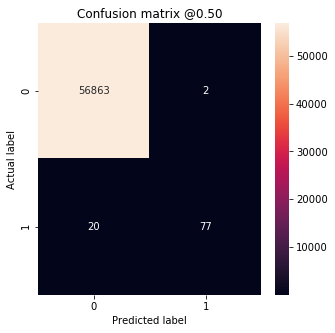

In [40]:
train_predictions_tomek_baseline = tomek_model_baseline.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_tomek_baseline = tomek_model_baseline.predict(test_features, batch_size=BATCH_SIZE)
tomek_results_baseline = tomek_model_baseline.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(tomek_model_baseline.metrics_names, tomek_results_baseline):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_tomek_baseline)

### modele elabore

In [47]:
tomek_model_elab = make_model_elab()
tomek_model_elab.load_weights(initial_weights_elab)

# Reset the bias to zero, since this dataset is balanced.
output_layer = tomek_model_elab.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = tomek_model_elab.fit(
    features_under_tomek, 
    labels_under_tomek,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train on 182262 samples, validate for 23 steps
Epoch 1/10
182262/182262 [==============================] - 36s 199us/sample - loss: 0.0081 - tp: 145.0000 - fp: 36.0000 - tn: 181924.0000 - fn: 157.0000 - accuracy: 0.9989 - precision: 0.8011 - recall: 0.4801 - auc: 0.8936 - val_loss: 0.0042 - val_tp: 76.0000 - val_fp: 15.0000 - val_tn: 45461.0000 - val_fn: 17.0000 - val_accuracy: 0.9993 - val_precision: 0.8352 - val_recall: 0.8172 - val_auc: 0.9404
Epoch 2/10
182262/182262 [==============================] - 31s 172us/sample - loss: 0.0050 - tp: 201.0000 - fp: 34.0000 - tn: 181926.0000 - fn: 101.0000 - accuracy: 0.9993 - precision: 0.8553 - recall: 0.6656 - auc: 0.9282 - val_loss: 0.0039 - val_tp: 76.0000 - val_fp: 18.0000 - val_tn: 45458.0000 - val_fn: 17.0000 - val_accuracy: 0.9992 - val_precision: 0.8085 - val_recall: 0.8172 - val_auc: 0.9405
Epoch 3/10
182262/182262 [==============================] - 31s 172us/sample - loss: 0.0041 - tp: 203.0000 - fp: 33.0000 - tn: 181927.0000 - fn: 

loss :  0.0025117061803692125
tp :  86.0
fp :  9.0
tn :  56856.0
fn :  11.0
accuracy :  0.99964887
precision :  0.9052632
recall :  0.88659793
auc :  0.96884805

Legitimate Transactions Detected (True Negatives):  56856
Legitimate Transactions Incorrectly Detected (False Positives):  9
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  86
Total Fraudulent Transactions:  97


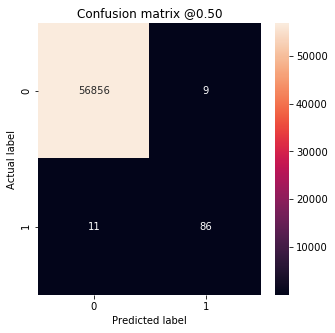

In [48]:
train_predictions_tomek_elab = tomek_model_elab.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_tomek_elab = tomek_model_elab.predict(test_features, batch_size=BATCH_SIZE)
tomek_results_elab = tomek_model_elab.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(tomek_model_elab.metrics_names, tomek_results_elab):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_tomek_elab)

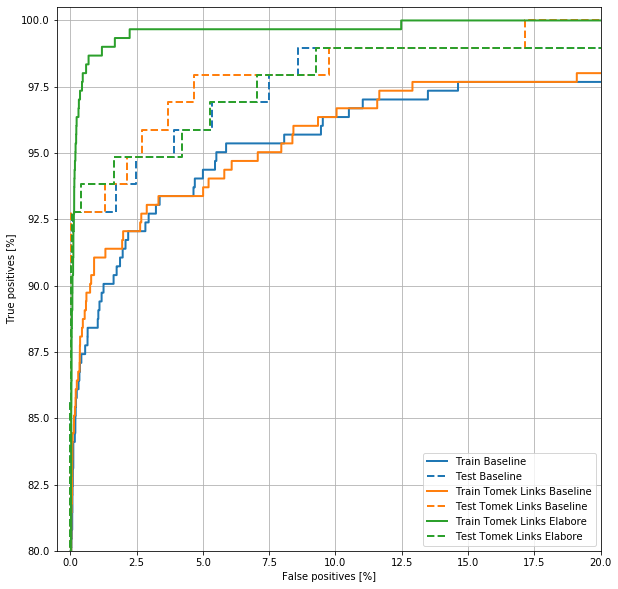

In [84]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Tomek Links Baseline", train_labels, train_predictions_tomek_baseline, color=colors[1])
plot_roc("Test Tomek Links Baseline", test_labels, test_predictions_tomek_baseline, color=colors[1], linestyle='--')

plot_roc("Train Tomek Links Elabore", train_labels, train_predictions_tomek_elab, color=colors[2])
plot_roc("Test Tomek Links Elabore", test_labels, test_predictions_tomek_elab, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

### Random Under Sampling

In [88]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy="majority")
train_features_RandomUnderSampler, train_labels_RandomUnderSampler = undersampler.fit_resample(train_features, train_labels)

In [89]:
randomUnderSampler_model_baseline = make_model_baseline()
randomUnderSampler_model_baseline.load_weights(initial_weights_baseline)

# Reset the bias to zero, since this dataset is balanced.
output_layer = adasyn_model_baseline.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = randomUnderSampler_model_baseline.fit(
    train_features_RandomUnderSampler,
    train_labels_RandomUnderSampler,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train on 604 samples, validate for 23 steps
Epoch 1/100
604/604 [==============================] - 2s 4ms/sample - loss: 2.1730 - tp: 48.0000 - fp: 2.0000 - tn: 300.0000 - fn: 254.0000 - accuracy: 0.5762 - precision: 0.9600 - recall: 0.1589 - auc: 0.7215 - val_loss: 0.0144 - val_tp: 17.0000 - val_fp: 59.0000 - val_tn: 45417.0000 - val_fn: 76.0000 - val_accuracy: 0.9970 - val_precision: 0.2237 - val_recall: 0.1828 - val_auc: 0.8938
Epoch 2/100
604/604 [==============================] - 0s 393us/sample - loss: 1.5684 - tp: 94.0000 - fp: 1.0000 - tn: 301.0000 - fn: 208.0000 - accuracy: 0.6540 - precision: 0.9895 - recall: 0.3113 - auc: 0.7918 - val_loss: 0.0147 - val_tp: 43.0000 - val_fp: 78.0000 - val_tn: 45398.0000 - val_fn: 50.0000 - val_accuracy: 0.9972 - val_precision: 0.3554 - val_recall: 0.4624 - val_auc: 0.9120
Epoch 3/100
604/604 [==============================] - 0s 377us/sample - loss: 1.1504 - tp: 123.0000 - fp: 2.0000 - tn: 300.0000 - fn: 179.0000 - accuracy: 0.7003 - precisi

Epoch 22/100
604/604 [==============================] - 0s 406us/sample - loss: 0.3236 - tp: 254.0000 - fp: 10.0000 - tn: 292.0000 - fn: 48.0000 - accuracy: 0.9040 - precision: 0.9621 - recall: 0.8411 - auc: 0.9462 - val_loss: 0.0786 - val_tp: 80.0000 - val_fp: 878.0000 - val_tn: 44598.0000 - val_fn: 13.0000 - val_accuracy: 0.9804 - val_precision: 0.0835 - val_recall: 0.8602 - val_auc: 0.9668
Epoch 23/100
604/604 [==============================] - 0s 376us/sample - loss: 0.3186 - tp: 256.0000 - fp: 14.0000 - tn: 288.0000 - fn: 46.0000 - accuracy: 0.9007 - precision: 0.9481 - recall: 0.8477 - auc: 0.9505 - val_loss: 0.0816 - val_tp: 81.0000 - val_fp: 912.0000 - val_tn: 44564.0000 - val_fn: 12.0000 - val_accuracy: 0.9797 - val_precision: 0.0816 - val_recall: 0.8710 - val_auc: 0.9669
Epoch 24/100
604/604 [==============================] - 0s 395us/sample - loss: 0.2748 - tp: 256.0000 - fp: 11.0000 - tn: 291.0000 - fn: 46.0000 - accuracy: 0.9056 - precision: 0.9588 - recall: 0.8477 - auc: 

Epoch 43/100
604/604 [==============================] - 0s 376us/sample - loss: 0.2087 - tp: 270.0000 - fp: 10.0000 - tn: 292.0000 - fn: 32.0000 - accuracy: 0.9305 - precision: 0.9643 - recall: 0.8940 - auc: 0.9717 - val_loss: 0.1199 - val_tp: 81.0000 - val_fp: 1384.0000 - val_tn: 44092.0000 - val_fn: 12.0000 - val_accuracy: 0.9694 - val_precision: 0.0553 - val_recall: 0.8710 - val_auc: 0.9724
Epoch 44/100
604/604 [==============================] - 0s 388us/sample - loss: 0.2373 - tp: 260.0000 - fp: 13.0000 - tn: 289.0000 - fn: 42.0000 - accuracy: 0.9089 - precision: 0.9524 - recall: 0.8609 - auc: 0.9667 - val_loss: 0.1236 - val_tp: 81.0000 - val_fp: 1437.0000 - val_tn: 44039.0000 - val_fn: 12.0000 - val_accuracy: 0.9682 - val_precision: 0.0534 - val_recall: 0.8710 - val_auc: 0.9725
Epoch 45/100
604/604 [==============================] - 0s 375us/sample - loss: 0.2342 - tp: 269.0000 - fp: 11.0000 - tn: 291.0000 - fn: 33.0000 - accuracy: 0.9272 - precision: 0.9607 - recall: 0.8907 - auc

Epoch 64/100
604/604 [==============================] - 0s 368us/sample - loss: 0.2002 - tp: 276.0000 - fp: 17.0000 - tn: 285.0000 - fn: 26.0000 - accuracy: 0.9288 - precision: 0.9420 - recall: 0.9139 - auc: 0.9729 - val_loss: 0.1353 - val_tp: 83.0000 - val_fp: 1702.0000 - val_tn: 43774.0000 - val_fn: 10.0000 - val_accuracy: 0.9624 - val_precision: 0.0465 - val_recall: 0.8925 - val_auc: 0.9749
Epoch 65/100
604/604 [==============================] - 0s 378us/sample - loss: 0.1850 - tp: 272.0000 - fp: 12.0000 - tn: 290.0000 - fn: 30.0000 - accuracy: 0.9305 - precision: 0.9577 - recall: 0.9007 - auc: 0.9749 - val_loss: 0.1342 - val_tp: 83.0000 - val_fp: 1678.0000 - val_tn: 43798.0000 - val_fn: 10.0000 - val_accuracy: 0.9630 - val_precision: 0.0471 - val_recall: 0.8925 - val_auc: 0.9751
Epoch 66/100
604/604 [==============================] - 0s 370us/sample - loss: 0.1808 - tp: 274.0000 - fp: 9.0000 - tn: 293.0000 - fn: 28.0000 - accuracy: 0.9387 - precision: 0.9682 - recall: 0.9073 - auc:

Epoch 85/100
604/604 [==============================] - 0s 400us/sample - loss: 0.1910 - tp: 276.0000 - fp: 15.0000 - tn: 287.0000 - fn: 26.0000 - accuracy: 0.9321 - precision: 0.9485 - recall: 0.9139 - auc: 0.9755 - val_loss: 0.1455 - val_tp: 83.0000 - val_fp: 1920.0000 - val_tn: 43556.0000 - val_fn: 10.0000 - val_accuracy: 0.9576 - val_precision: 0.0414 - val_recall: 0.8925 - val_auc: 0.9760
Epoch 86/100
604/604 [==============================] - 0s 370us/sample - loss: 0.1594 - tp: 281.0000 - fp: 8.0000 - tn: 294.0000 - fn: 21.0000 - accuracy: 0.9520 - precision: 0.9723 - recall: 0.9305 - auc: 0.9785 - val_loss: 0.1437 - val_tp: 83.0000 - val_fp: 1901.0000 - val_tn: 43575.0000 - val_fn: 10.0000 - val_accuracy: 0.9581 - val_precision: 0.0418 - val_recall: 0.8925 - val_auc: 0.9758
Epoch 87/100
604/604 [==============================] - 0s 367us/sample - loss: 0.1780 - tp: 279.0000 - fp: 12.0000 - tn: 290.0000 - fn: 23.0000 - accuracy: 0.9421 - precision: 0.9588 - recall: 0.9238 - auc:

loss :  0.029792067454249845
tp :  88.0
fp :  525.0
tn :  56340.0
fn :  9.0
accuracy :  0.9906253
precision :  0.14355628
recall :  0.9072165
auc :  0.9525004

Legitimate Transactions Detected (True Negatives):  54444
Legitimate Transactions Incorrectly Detected (False Positives):  2421
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  91
Total Fraudulent Transactions:  97


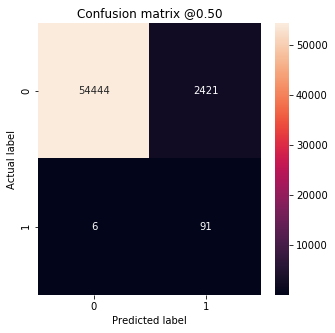

In [90]:
train_predictions_randomUnderSampler_baseline = randomUnderSampler_model_baseline.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_randomUnderSampler_baseline = randomUnderSampler_model_baseline.predict(test_features, batch_size=BATCH_SIZE)
randomUnderSampler_results_baseline = randomUnderSampler_model_baseline.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(randomUnderSampler_model_baseline.metrics_names, adasyn_results_baseline):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_randomUnderSampler_baseline)

### Modele Elaboré

In [92]:
randomUnderSampler_model_elab = make_model_elab()
randomUnderSampler_model_elab.load_weights(initial_weights_elab)

# Reset the bias to zero, since this dataset is balanced.
output_layer = randomUnderSampler_model_elab.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = randomUnderSampler_model_elab.fit(
    train_features_RandomUnderSampler,
    train_labels_RandomUnderSampler,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train on 604 samples, validate for 23 steps
Epoch 1/100
604/604 [==============================] - 3s 4ms/sample - loss: 0.6978 - tp: 151.0000 - fp: 93.0000 - tn: 209.0000 - fn: 151.0000 - accuracy: 0.5960 - precision: 0.6189 - recall: 0.5000 - auc: 0.5942 - val_loss: 0.6812 - val_tp: 90.0000 - val_fp: 20392.0000 - val_tn: 25084.0000 - val_fn: 3.0000 - val_accuracy: 0.5524 - val_precision: 0.0044 - val_recall: 0.9677 - val_auc: 0.9538
Epoch 2/100
604/604 [==============================] - 0s 403us/sample - loss: 0.4681 - tp: 267.0000 - fp: 85.0000 - tn: 217.0000 - fn: 35.0000 - accuracy: 0.8013 - precision: 0.7585 - recall: 0.8841 - auc: 0.9119 - val_loss: 0.4324 - val_tp: 83.0000 - val_fp: 1899.0000 - val_tn: 43577.0000 - val_fn: 10.0000 - val_accuracy: 0.9581 - val_precision: 0.0419 - val_recall: 0.8925 - val_auc: 0.9576
Epoch 3/100
604/604 [==============================] - 0s 413us/sample - loss: 0.3217 - tp: 262.0000 - fp: 19.0000 - tn: 283.0000 - fn: 40.0000 - accuracy: 0.9023 - 

604/604 [==============================] - 0s 426us/sample - loss: 0.0727 - tp: 294.0000 - fp: 6.0000 - tn: 296.0000 - fn: 8.0000 - accuracy: 0.9768 - precision: 0.9800 - recall: 0.9735 - auc: 0.9962 - val_loss: 0.1505 - val_tp: 84.0000 - val_fp: 2564.0000 - val_tn: 42912.0000 - val_fn: 9.0000 - val_accuracy: 0.9435 - val_precision: 0.0317 - val_recall: 0.9032 - val_auc: 0.9774
Epoch 00021: early stopping


loss :  0.11389503578547283
tp :  90.0
fp :  2308.0
tn :  54557.0
fn :  7.0
accuracy :  0.9593589
precision :  0.037531275
recall :  0.92783505
auc :  0.9936093

Legitimate Transactions Detected (True Negatives):  54557
Legitimate Transactions Incorrectly Detected (False Positives):  2308
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  90
Total Fraudulent Transactions:  97


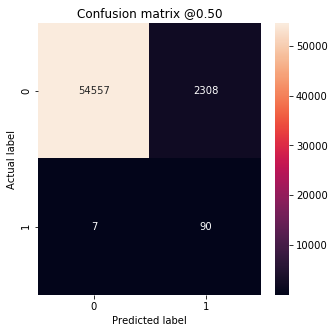

In [93]:
train_predictions_randomUnderSampler_elab = randomUnderSampler_model_elab.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_randomUnderSampler_elab = randomUnderSampler_model_elab.predict(test_features, batch_size=BATCH_SIZE)
randomUnderSampler_results_elab = randomUnderSampler_model_elab.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(randomUnderSampler_model_elab.metrics_names, randomUnderSampler_results_elab):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_randomUnderSampler_elab)

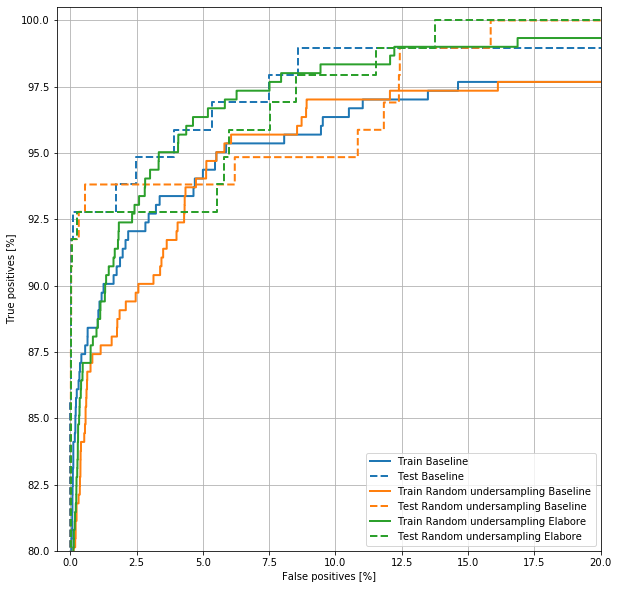

In [94]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Random undersampling Baseline", train_labels, train_predictions_randomUnderSampler_baseline, color=colors[1])
plot_roc("Test Random undersampling Baseline", test_labels, test_predictions_randomUnderSampler_baseline, color=colors[1], linestyle='--')

plot_roc("Train Random undersampling Elabore", train_labels, train_predictions_randomUnderSampler_elab, color=colors[2])
plot_roc("Test Random undersampling Elabore", test_labels, test_predictions_randomUnderSampler_elab, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

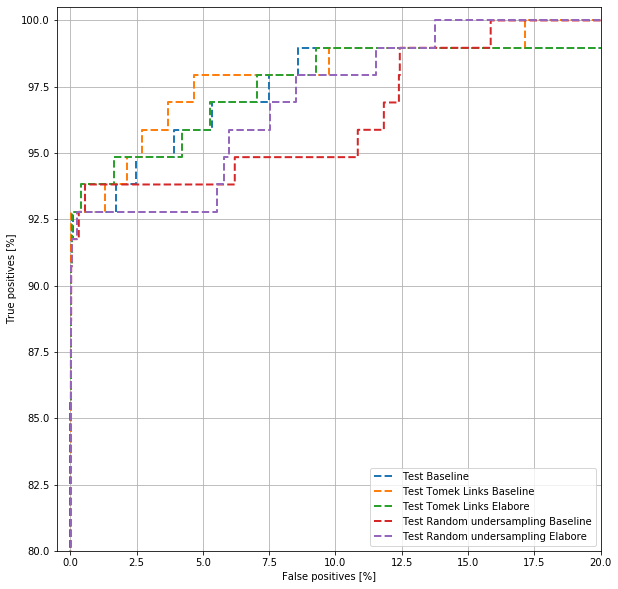

In [139]:
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Test Tomek Links Baseline", test_labels, test_predictions_tomek_baseline, color=colors[1], linestyle='--')
plot_roc("Test Tomek Links Elabore", test_labels, test_predictions_tomek_elab, color=colors[2], linestyle='--')
plot_roc("Test Random undersampling Baseline", test_labels, test_predictions_randomUnderSampler_baseline, color=colors[3], linestyle='--')
plot_roc("Test Random undersampling Elabore", test_labels, test_predictions_randomUnderSampler_elab, color=colors[4], linestyle='--')

plt.legend(loc='lower right')

### Approches Hybrides

### RandomOverSampling + Tomek Links

In [49]:
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler

over_sampling = RandomOverSampler(sampling_strategy="minority")

features_RandomOverSampler, labels_RandomOverSampler = over_sampling.fit_resample(train_features, train_labels)

underTomek = TomekLinks()
features_ROS_tomek, labels_ROS_tomek = underTomek.fit_resample(features_RandomOverSampler, labels_RandomOverSampler)

In [53]:
ROS_tomek_model_baseline = make_model_baseline()
ROS_tomek_model_baseline.load_weights(initial_weights_baseline)

# Reset the bias to zero, since this dataset is balanced.
output_layer = ROS_tomek_model_baseline.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = ROS_tomek_model_baseline.fit(
    features_ROS_tomek, 
    labels_ROS_tomek,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train on 363948 samples, validate for 23 steps
Epoch 1/10
363948/363948 [==============================] - 58s 160us/sample - loss: 0.1304 - tp: 169850.0000 - fp: 7248.0000 - tn: 174726.0000 - fn: 12124.0000 - accuracy: 0.9468 - precision: 0.9591 - recall: 0.9334 - auc: 0.9896 - val_loss: 0.0341 - val_tp: 81.0000 - val_fp: 436.0000 - val_tn: 45040.0000 - val_fn: 12.0000 - val_accuracy: 0.9902 - val_precision: 0.1567 - val_recall: 0.8710 - val_auc: 0.9709
Epoch 2/10
363948/363948 [==============================] - 56s 153us/sample - loss: 0.0705 - tp: 176345.0000 - fp: 4589.0000 - tn: 177385.0000 - fn: 5629.0000 - accuracy: 0.9719 - precision: 0.9746 - recall: 0.9691 - auc: 0.9969 - val_loss: 0.0285 - val_tp: 81.0000 - val_fp: 403.0000 - val_tn: 45073.0000 - val_fn: 12.0000 - val_accuracy: 0.9909 - val_precision: 0.1674 - val_recall: 0.8710 - val_auc: 0.9487
Epoch 3/10
363948/363948 [==============================] - 58s 159us/sample - loss: 0.0641 - tp: 177211.0000 - fp: 4750.0000 - tn

loss :  0.02031237106733784
tp :  90.0
fp :  324.0
tn :  56541.0
fn :  7.0
accuracy :  0.9941891
precision :  0.2173913
recall :  0.92783505
auc :  0.9682672

Legitimate Transactions Detected (True Negatives):  56541
Legitimate Transactions Incorrectly Detected (False Positives):  324
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  90
Total Fraudulent Transactions:  97


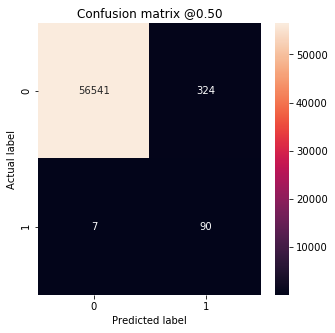

In [59]:
train_predictions_ROS_tomek_baseline = ROS_tomek_model_baseline.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_ROS_tomek_baseline = ROS_tomek_model_baseline.predict(test_features, batch_size=BATCH_SIZE)
ROS_tomek_results_baseline = ROS_tomek_model_baseline.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(ROS_tomek_model_baseline.metrics_names, ROS_tomek_results_baseline):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_ROS_tomek_baseline)

###  modele elaboré

In [54]:
ROS_tomek_elab = make_model_elab()
ROS_tomek_elab.load_weights(initial_weights_elab)

# Reset the bias to zero, since this dataset is balanced.
output_layer = ROS_tomek_elab.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = ROS_tomek_elab.fit(
    features_ROS_tomek, 
    labels_ROS_tomek,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train on 363948 samples, validate for 23 steps
Epoch 1/10
363948/363948 [==============================] - 69s 191us/sample - loss: 0.0260 - tp: 180728.0000 - fp: 1654.0000 - tn: 180320.0000 - fn: 1246.0000 - accuracy: 0.9920 - precision: 0.9909 - recall: 0.9932 - auc: 0.9992 - val_loss: 0.0171 - val_tp: 79.0000 - val_fp: 82.0000 - val_tn: 45394.0000 - val_fn: 14.0000 - val_accuracy: 0.9979 - val_precision: 0.4907 - val_recall: 0.8495 - val_auc: 0.9294
Epoch 2/10
363948/363948 [==============================] - 79s 217us/sample - loss: 0.0072 - tp: 181821.0000 - fp: 396.0000 - tn: 181578.0000 - fn: 153.0000 - accuracy: 0.9985 - precision: 0.9978 - recall: 0.9992 - auc: 0.9996 - val_loss: 0.0123 - val_tp: 79.0000 - val_fp: 41.0000 - val_tn: 45435.0000 - val_fn: 14.0000 - val_accuracy: 0.9988 - val_precision: 0.6583 - val_recall: 0.8495 - val_auc: 0.9244
Epoch 3/10
363948/363948 [==============================] - 64s 175us/sample - loss: 0.0056 - tp: 181854.0000 - fp: 311.0000 - tn: 1816

loss :  0.01187763329814314
tp :  90.0
fp :  23.0
tn :  56842.0
fn :  7.0
accuracy :  0.99947333
precision :  0.79646015
recall :  0.92783505
auc :  0.96375364

Legitimate Transactions Detected (True Negatives):  56842
Legitimate Transactions Incorrectly Detected (False Positives):  23
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  90
Total Fraudulent Transactions:  97


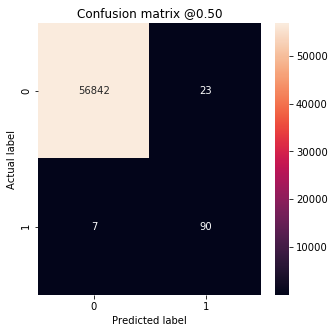

In [55]:
train_predictions_ROS_tomek_elab = ROS_tomek_elab.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_ROS_tomek_elab = ROS_tomek_elab.predict(test_features, batch_size=BATCH_SIZE)
ROS_tomek_results_elab = ROS_tomek_elab.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(ROS_tomek_elab.metrics_names, ROS_tomek_results_elab):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_ROS_tomek_elab)

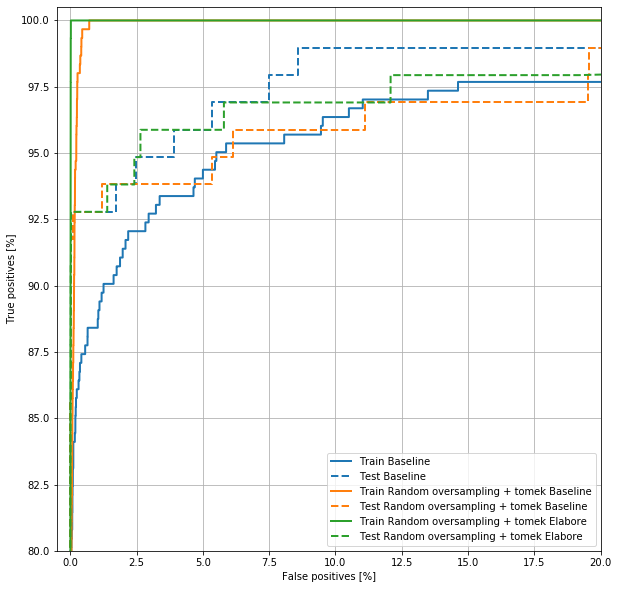

In [98]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Random oversampling + tomek Baseline", train_labels, train_predictions_ROS_tomek_baseline, color=colors[1])
plot_roc("Test Random oversampling + tomek Baseline", test_labels, test_predictions_ROS_tomek_baseline, color=colors[1], linestyle='--')

plot_roc("Train Random oversampling + tomek Elabore", train_labels, train_predictions_ROS_tomek_elab, color=colors[2])
plot_roc("Test Random oversampling + tomek Elabore", test_labels, test_predictions_ROS_tomek_elab, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

### SMOTE + Tomek Links

In [11]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)

features_SMOTE_tomek, labels_SMOTE_tomek = smt.fit_sample(train_features, train_labels)



In [56]:
smote_tomek_model_baseline = make_model_baseline()
smote_tomek_model_baseline.load_weights(initial_weights_baseline)

# Reset the bias to zero, since this dataset is balanced.
output_layer = smote_tomek_model_baseline.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = smote_tomek_model_baseline.fit(
    features_SMOTE_tomek,
    labels_SMOTE_tomek,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train on 363948 samples, validate for 23 steps
Epoch 1/10
363948/363948 [==============================] - 57s 158us/sample - loss: 0.1279 - tp: 170413.0000 - fp: 7290.0000 - tn: 174684.0000 - fn: 11561.0000 - accuracy: 0.9482 - precision: 0.9590 - recall: 0.9365 - auc: 0.9901 - val_loss: 0.0333 - val_tp: 82.0000 - val_fp: 440.0000 - val_tn: 45036.0000 - val_fn: 11.0000 - val_accuracy: 0.9901 - val_precision: 0.1571 - val_recall: 0.8817 - val_auc: 0.9666
Epoch 2/10
363948/363948 [==============================] - 57s 155us/sample - loss: 0.0697 - tp: 176221.0000 - fp: 4625.0000 - tn: 177349.0000 - fn: 5753.0000 - accuracy: 0.9715 - precision: 0.9744 - recall: 0.9684 - auc: 0.9968 - val_loss: 0.0283 - val_tp: 81.0000 - val_fp: 395.0000 - val_tn: 45081.0000 - val_fn: 12.0000 - val_accuracy: 0.9911 - val_precision: 0.1702 - val_recall: 0.8710 - val_auc: 0.9542
Epoch 3/10
363948/363948 [==============================] - 62s 170us/sample - loss: 0.0642 - tp: 177044.0000 - fp: 4797.0000 - tn

loss :  0.0213609254280987
tp :  90.0
fp :  308.0
tn :  56557.0
fn :  7.0
accuracy :  0.99447
precision :  0.22613065
recall :  0.92783505
auc :  0.96315163

Legitimate Transactions Detected (True Negatives):  56557
Legitimate Transactions Incorrectly Detected (False Positives):  308
Fraudulent Transactions Missed (False Negatives):  7
Fraudulent Transactions Detected (True Positives):  90
Total Fraudulent Transactions:  97


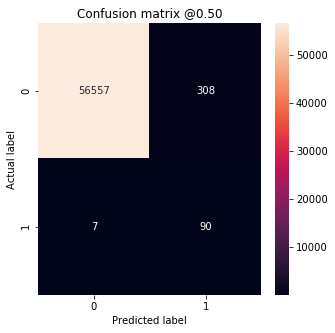

In [58]:
train_predictions_SMOTE_tomek_baseline = smote_tomek_model_baseline.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_SMOTE_tomek_baseline = smote_tomek_model_baseline.predict(test_features, batch_size=BATCH_SIZE)
SMOTE_tomek_results_baseline = smote_tomek_model_baseline.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(smote_tomek_model_baseline.metrics_names, SMOTE_tomek_results_baseline):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_SMOTE_tomek_baseline)

### modele elaboré

In [57]:
smote_tomek_elab = make_model_elab()
smote_tomek_elab.load_weights(initial_weights_elab)

# Reset the bias to zero, since this dataset is balanced.
output_layer = smote_tomek_elab.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = smote_tomek_elab.fit(
    features_SMOTE_tomek, 
    labels_SMOTE_tomek,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train on 363948 samples, validate for 23 steps
Epoch 1/10
363948/363948 [==============================] - 72s 199us/sample - loss: 0.0264 - tp: 180673.0000 - fp: 1688.0000 - tn: 180286.0000 - fn: 1301.0000 - accuracy: 0.9918 - precision: 0.9907 - recall: 0.9929 - auc: 0.9992 - val_loss: 0.0119 - val_tp: 79.0000 - val_fp: 67.0000 - val_tn: 45409.0000 - val_fn: 14.0000 - val_accuracy: 0.9982 - val_precision: 0.5411 - val_recall: 0.8495 - val_auc: 0.9401
Epoch 2/10
363948/363948 [==============================] - 65s 178us/sample - loss: 0.0074 - tp: 181821.0000 - fp: 425.0000 - tn: 181549.0000 - fn: 153.0000 - accuracy: 0.9984 - precision: 0.9977 - recall: 0.9992 - auc: 0.9997 - val_loss: 0.0142 - val_tp: 79.0000 - val_fp: 48.0000 - val_tn: 45428.0000 - val_fn: 14.0000 - val_accuracy: 0.9986 - val_precision: 0.6220 - val_recall: 0.8495 - val_auc: 0.9297
Epoch 3/10
363948/363948 [==============================] - 66s 182us/sample - loss: 0.0056 - tp: 181875.0000 - fp: 322.0000 - tn: 1816

loss :  0.010109792202041664
tp :  89.0
fp :  27.0
tn :  56838.0
fn :  8.0
accuracy :  0.99938554
precision :  0.76724136
recall :  0.91752577
auc :  0.96374995

Legitimate Transactions Detected (True Negatives):  56838
Legitimate Transactions Incorrectly Detected (False Positives):  27
Fraudulent Transactions Missed (False Negatives):  8
Fraudulent Transactions Detected (True Positives):  89
Total Fraudulent Transactions:  97


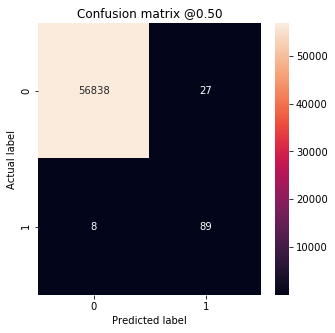

In [60]:
train_predictions_smote_tomek_elab = smote_tomek_elab.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_smote_tomek_elab = smote_tomek_elab.predict(test_features, batch_size=BATCH_SIZE)
smote_tomek_results_elab = smote_tomek_elab.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(smote_tomek_elab.metrics_names, smote_tomek_results_elab):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_smote_tomek_elab)

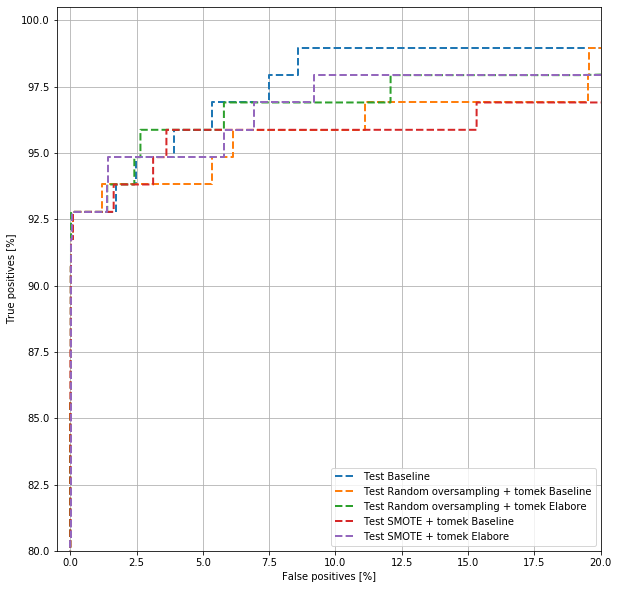

In [140]:
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Test Random oversampling + tomek Baseline", test_labels, test_predictions_ROS_tomek_baseline, color=colors[1], linestyle='--')
plot_roc("Test Random oversampling + tomek Elabore", test_labels, test_predictions_ROS_tomek_elab, color=colors[2], linestyle='--')
plot_roc("Test SMOTE + tomek Baseline", test_labels, test_predictions_SMOTE_tomek_baseline, color=colors[3], linestyle='--')
plot_roc("Test SMOTE + tomek Elabore", test_labels, test_predictions_smote_tomek_elab, color=colors[4], linestyle='--')
plt.legend(loc='lower right')